In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu
import numpy as np
import shutil

In [2]:
new_model_ws = "pest_mc2"

In [3]:
m = flopy.modflow.Modflow.load("box.nam",model_ws=os.path.join("..","model"))

In [4]:
m.lpf.hk[0] = 2.5
m.rch.rech = 0.000025
m.model_ws = "temp"
m.write_input()


changing model workspace...
   temp


In [5]:
pp_props = [["lpf.hk",0]]
#pp_props = None
const_props = [["rch.rech",0],["rch.rech",1]]
bc_props = [["drn.cond",[0,1]],["riv.cond",[0,1]]]
hds_kperk = [[0,0],[1,0]]
pst_helper = pyemu.helpers.PstFromFlopyModel(model='box.nam',org_model_ws="temp",new_model_ws=new_model_ws,
                                            pp_props=pp_props,remove_existing=True,
                                            const_props=const_props,bc_props=bc_props,
                                            hds_kperk=hds_kperk,pp_space=8)


2017-12-04 14:53:27.728451 starting: loading flopy model
2017-12-04 14:53:27.791402 finished: loading flopy model took: 0:00:00.062951
2017-12-04 14:53:27.791629 starting: updating model attributes
2017-12-04 14:53:27.791877 finished: updating model attributes took: 0:00:00.000248
2017-12-04 14:53:27.792064 WARNING: removing existing 'new_model_ws

creating model workspace...
   pest_mc2

changing model workspace...
   pest_mc2
2017-12-04 14:53:27.856410 starting: writing new modflow input files
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vk: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:rech_2: resetting 'how' to external
2017-12-04 14:53:27

/Users/mnfienen/Documents/GIT/pyemu/pyemu/utils/gw_utils.py:248: UserWarning: pp_file_to_dataframe has moved to pp_utils
  warnings.warn("pp_file_to_dataframe has moved to pp_utils")


arr_mlt/hk0.dat_pp 0.99999998488 1.0 1e-10
2017-12-04 14:53:50.048657 forward_run line:pyemu.helpers.apply_array_pars()

2017-12-04 14:53:50.048882 starting: processing obs type mflist water budget obs
run():inschek pest_mc2/flux.dat.ins pest_mc2/flux.dat
run():inschek pest_mc2/vol.dat.ins pest_mc2/vol.dat
run():inschek pest_mc2/flux.dat.ins pest_mc2/flux.dat
run():inschek pest_mc2/vol.dat.ins pest_mc2/vol.dat
2017-12-04 14:53:50.159400 forward_run line:pyemu.gw_utils.apply_mflist_budget_obs('box.list',flx_filename='flux.dat',vol_filename='vol.dat',start_datetime='1-1-1970')
2017-12-04 14:53:50.159518 finished: processing obs type mflist water budget obs took: 0:00:00.110636
2017-12-04 14:53:50.159563 starting: processing obs type hyd file
2017-12-04 14:53:50.159675 finished: processing obs type hyd file took: 0:00:00.000112
2017-12-04 14:53:50.159725 starting: processing obs type external obs-sim smp files
2017-12-04 14:53:50.159805 finished: processing obs type external obs-sim smp f

/Users/mnfienen/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mnfienen/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
pst = pst_helper.pst

df = pd.read_csv(os.path.join("..","model","_setup_box.hds.csv"))
df.index = df.obsnme
obs = pst.observation_data
obs.loc[:,"weight"] = 0.0
obs.loc[df.obsnme,"weight"] = df.weight
obs.loc[df.obsnme,"obsval"] = df.obsval
obs.loc[obs.weight>0, "obgnme"] = 'heads_cal'

## Make some flux observations

In [7]:
df = pd.read_csv(os.path.join("..","model","_setup_box.list.csv"))
obs.loc[obs.obgnme=="flx_river_l","obsval"] = df.loc[:,"river_leakage"].values
obs.loc[obs.obgnme=="flx_drains","obsval"] = df.loc[:,"drains"].values



In [8]:
obs.loc[obs.apply(lambda x : "flx_river_l" in x.obgnme and
                  "0102" in x.obsnme,axis=1),"weight"] = 1.0
obs.loc[obs.apply(lambda x : "flx_drains" in x.obgnme and 
                  "0102" in x.obsnme,axis=1),"weight"] = 1.0

In [9]:
pst.observation_data.obsnme.unique()

array(['hds_00_000_000_000', 'hds_00_000_001_000', 'hds_00_000_002_000',
       ..., 'vol_storage_19700412', 'vol_total_19700412',
       'vol_wells_19700412'], dtype=object)

In [10]:
pst.nnz_obs
forecasts = []
forecasts.append(obs.loc[obs.obgnme=="flx_river_l","obsnme"][-1])
forecasts.append(obs.loc[obs.obgnme=="flx_drains","obsnme"][-1])
forecasts.append("hds_00_080_060_001")
forecasts.append("hds_00_050_050_001")

pst.pestpp_options["forecasts"] = ','.join(forecasts)
pst.control_data.noptmax = 0
pst.write(os.path.join(new_model_ws,"box.pst"))
pyemu.helpers.run("pestpp box.pst",cwd=new_model_ws)

run():pestpp box.pst


In [11]:
pst = pyemu.Pst(os.path.join(new_model_ws,"box.pst"))

In [12]:
pst.nnz_obs_names

['hds_00_020_030_000',
 'hds_00_020_060_000',
 'hds_00_040_030_000',
 'hds_00_040_060_000',
 'hds_00_060_030_000',
 'hds_00_060_060_000',
 'hds_00_080_030_000',
 'hds_00_080_060_000',
 'flx_drains_19700102',
 'flx_river_l_19700102']

In [13]:
pst.res.loc[pst.nnz_obs_names,:]

name        group     measured  \
name                                                                   
hds_00_020_030_000      hds_00_020_030_000    heads_cal    -0.018876   
hds_00_020_060_000      hds_00_020_060_000    heads_cal     0.223111   
hds_00_040_030_000      hds_00_040_030_000    heads_cal    -1.118615   
hds_00_040_060_000      hds_00_040_060_000    heads_cal    -0.422204   
hds_00_060_030_000      hds_00_060_030_000    heads_cal    -2.323823   
hds_00_060_060_000      hds_00_060_060_000    heads_cal    -1.637360   
hds_00_080_030_000      hds_00_080_030_000    heads_cal    -4.534806   
hds_00_080_060_000      hds_00_080_060_000    heads_cal    -3.497677   
flx_drains_19700102    flx_drains_19700102   flx_drains  -414.232788   
flx_river_l_19700102  flx_river_l_19700102  flx_river_l -1389.517456   

                        modelled    residual  weight  
name                                                  
hds_00_020_030_000     -4.520337    4.501461     2.0  
hds_00_020_060_000     -4.357847    4.580958     2.0  
hds_00_040_030_000     -5.184079    4.065464     2.0  
hds_00_040_060_000     -4.844365    4.422161     2.0  
hds_00_060_030_000     -6.266079    3.942256     2.0  
hds_00_060_060_000     -5.558151    3.920791     2.0  
hds_00_080_030_000     -7.168790    2.633984     2.0  
hds_00_080_060_000     -6.391021    2.893344     2.0  
flx_drains_19700102  -194.172104 -220.060684     1.0  
flx_river_l_19700102 -780.827881 -608.689575     1.0

# Let's mess around with PHI a bit

In [14]:
pst.phi_components

{'flx_constan': 0.0,
 'flx_drains': 48426.7047340931,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 370502.9990070689,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'heads_cal': 494.220509091928,
 'obgnme': 0.0,
 'vol_constan': 0.0,
 'vol_drains': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

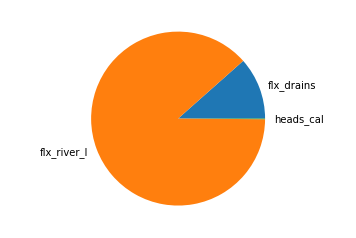

In [15]:
comps = pst.phi_components_normalized
starting_components = {i: comps[i] for i in comps if comps[i] >0 }
plt.axis('equal')
plt.pie([float(v) for v in starting_components.values()], labels=[k for k in starting_components.keys()]);

## clearly this is way out of balance! We want heads to be 20% and fluxes each to be 40%

In [16]:
pst.nnz_obs_groups

['flx_drains', 'flx_river_l', 'heads_cal']

In [17]:
groups = ['flx_drains', 'flx_river_l', 'heads_cal']

In [18]:
target_phi = [0.40,0.40,0.20]

In [19]:
newcomponents = dict(zip(groups,[i*pst.phi for i in target_phi]))

In [20]:
pst.adjust_weights(obsgrp_dict=newcomponents)
pst.phi_components

{'flx_constan': 0.0,
 'flx_drains': 167769.56970010157,
 'flx_in-out': 0.0,
 'flx_percent': 0.0,
 'flx_recharg': 0.0,
 'flx_river_l': 167769.56970010162,
 'flx_storage': 0.0,
 'flx_total': 0.0,
 'flx_wells': 0.0,
 'heads_cal': 83884.7848500508,
 'obgnme': 0.0,
 'vol_constan': 0.0,
 'vol_drains': 0.0,
 'vol_in-out': 0.0,
 'vol_percent': 0.0,
 'vol_recharg': 0.0,
 'vol_river_l': 0.0,
 'vol_storage': 0.0,
 'vol_total': 0.0,
 'vol_wells': 0.0}

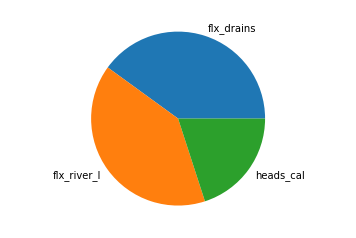

In [21]:
newcomps = pst.phi_components_normalized
new_components = {i: newcomps[i] for i in newcomps if newcomps[i] >0 }
plt.axis('equal')
plt.pie([float(v) for v in new_components.values()], labels=[k for k in new_components.keys()]);

# Let's do Monte Carlo prior to calibration

In [22]:
mc = pyemu.MonteCarlo(pst=pst, parcov=os.path.join(new_model_ws,'box_pest.pst.prior.cov'))

In [23]:
mc.draw(num_reals=250,enforce_bounds="reset")

In [24]:
mc.parensemble.loc[10]


parnme
rech0_cn        1.05382
rech1_cn       0.946307
drncond_000    0.267741
rivcond_000    0.648807
hk0000          1.92325
hk0001          1.36431
hk0002          1.79986
hk0003          5.37523
hk0004          4.51518
hk0005          0.72026
hk0006         0.492003
hk0007          1.95708
hk0008         0.881541
hk0009          1.06984
hk0010         0.803609
hk0011         0.414094
hk0012          3.77379
hk0013          2.65011
hk0014          2.24117
hk0015          2.18814
hk0016          2.07222
hk0017         0.516857
hk0018          1.92611
hk0019         0.428634
hk0020           2.0096
hk0021          4.38347
hk0022          5.19525
hk0023          1.92067
hk0024          1.80411
hk0025           2.0484
                 ...   
hk0078          4.64193
hk0079          1.37608
hk0080         0.570707
hk0081         0.490389
hk0082         0.335637
hk0083         0.926901
hk0084         0.880873
hk0085          1.59251
hk0086          3.56538
hk0087          4.88801
hk0088   

In [25]:
mc.parensemble.to_csv(os.path.join(new_model_ws,'sweep_in.csv'))

In [26]:
def plot_first_10_reals(paren):
    arrs = []
    pp_df = pyemu.pp_utils.pp_tpl_to_dataframe(os.path.join(new_model_ws,"hk0pp.dat.tpl"))
    pp_df.loc[:,"iidx"] = pp_df.index
    for real in paren.index.values[:10]:
        pp_df.index = pp_df.parnme
        pp_df.loc[:,"parval1"] = paren.loc[real,pp_df.parnme].T
        pp_df.index = pp_df.iidx
        arr = pyemu.geostats.fac2real(pp_df,os.path.join(new_model_ws,"pp_k0.fac"))
        arrs.append(np.log10(np.loadtxt(arr)))
    mx,mn = -1.0E+10,1.0e+10
    for arr in arrs:
        mx = max(mx,arr.max())
        mn = min(mn,arr.min())
    fig = plt.figure(figsize=(10,10))
    for i,arr in enumerate(arrs):
        ax = plt.subplot(2,5,i+1,aspect="equal")
        m.lpf.hk[0] = arr
        m.lpf.hk[0].plot(axes=[ax],alpha=0.5)
        ax.scatter(pp_df.x,pp_df.y,marker='.',color='k',s=4)
        ax.set_yticklabels([])
        ax.set_xticklabels([])

test.ref 0.172253694986 0.1722536949864021 -1e+30
test.ref 0.186080499757 0.18608049975740049 -1e+30
test.ref 0.189031691589 0.18903169158872152 -1e+30
test.ref 0.124488810543 0.1244888105428683 -1e+30
test.ref 0.1 0.1 -1e+30
test.ref 0.165523930301 0.16552393030129187 -1e+30
test.ref 0.154515667454 0.15451566745416725 -1e+30
test.ref 0.1 0.1 -1e+30
test.ref 0.140873665113 0.14087366511331437 -1e+30
test.ref 0.115380065888 0.11538006588761839 -1e+30


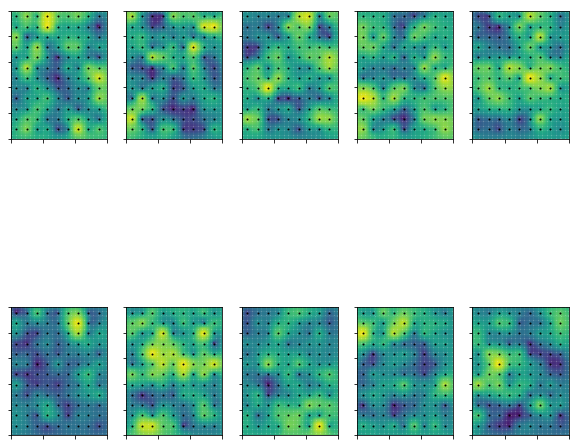

In [27]:
plot_first_10_reals(mc.parensemble)

In [28]:
pst.write(os.path.join(new_model_ws,"box.pst"))

In [29]:
pyemu.helpers.start_slaves(new_model_ws,exe_rel_path='sweep',
                           pst_rel_path="box.pst",num_slaves=15,master_dir="master")

master:sweep box.pst /h :4004 in master
slave:sweep box.pst /h localhost:4004 in ../slave_0
slave:sweep box.pst /h localhost:4004 in ../slave_1
slave:sweep box.pst /h localhost:4004 in ../slave_2
slave:sweep box.pst /h localhost:4004 in ../slave_3
slave:sweep box.pst /h localhost:4004 in ../slave_4
slave:sweep box.pst /h localhost:4004 in ../slave_5
slave:sweep box.pst /h localhost:4004 in ../slave_6
slave:sweep box.pst /h localhost:4004 in ../slave_7
slave:sweep box.pst /h localhost:4004 in ../slave_8
slave:sweep box.pst /h localhost:4004 in ../slave_9
slave:sweep box.pst /h localhost:4004 in ../slave_10
slave:sweep box.pst /h localhost:4004 in ../slave_11
slave:sweep box.pst /h localhost:4004 in ../slave_12
slave:sweep box.pst /h localhost:4004 in ../slave_13
slave:sweep box.pst /h localhost:4004 in ../slave_14


In [30]:
results = pd.read_csv(os.path.join("master","sweep_out.csv"))

In [31]:
results.head()

run_id  input_run_id  failed_flag            phi       meas_phi  regul_phi  \
0       0             0            0  704388.630522  704388.630522          0   
1       1             1            0  691174.351794  691174.351794          0   
2       2             2            0  457565.032885  457565.032885          0   
3       3             3            0  378052.626824  378052.626824          0   
4       4             4            0  245874.652775  245874.652775          0   

   FLX_CONSTAN     FLX_DRAINS  FLX_IN-OUT  FLX_PERCENT         ...          \
0            0  137009.202306           0            0         ...           
1            0  407519.710673           0            0         ...           
2            0  224772.799410           0            0         ...           
3            0  253929.533830           0            0         ...           
4            0    1849.490495           0            0         ...           

   VOL_WELLS_19700102  VOL_CONSTAN_19700412  VOL_DRAINS_19700412  \
0                -900                     0        -22116.210938   
1                -900                     0         -6953.860840   
2                -900                     0        -15955.873047   
3                -900                     0        -13968.376953   
4                -900                     0        -43504.617188   

   VOL_IN-OUT_19700412  VOL_PERCENT_19700412  VOL_RECHARG_19700412  \
0            -0.031250                     0         222823.484375   
1             0.046875                     0         171129.031250   
2            -0.078125                     0         206821.921875   
3             0.015625                     0         169247.281250   
4            -0.015625                     0         166249.656250   

   VOL_RIVER_L_19700412  VOL_STORAGE_19700412  VOL_TOTAL_19700412  \
0         -43717.269531         -46090.039062           -0.031250   
1         -72363.000000          19087.882812            0.046875   
2         -77503.218750          -2462.904297           -0.078125   
3        -104737.015625          60358.128906            0.015625   
4         -66422.703125          54577.660156           -0.015625   

   VOL_WELLS_19700412  
0             -110900  
1             -110900  
2             -110900  
3             -110900  
4             -110900  

[5 rows x 15062 columns]

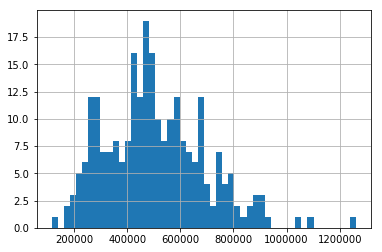

In [32]:
results.phi.hist(bins=50)

# Sweet as! No real need for rejection sampling but we probably ought to throw out the really big $\Phi$ values

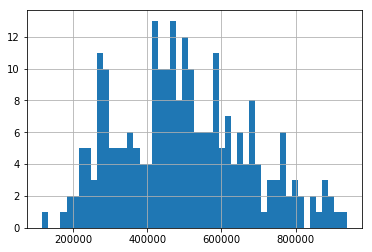

In [33]:
results = results.loc[results.phi<1e6]
results.phi.hist(bins=50)

In [34]:
forecasts

['flx_river_l_19700412',
 'flx_drains_19700412',
 'hds_00_080_060_001',
 'hds_00_050_050_001']

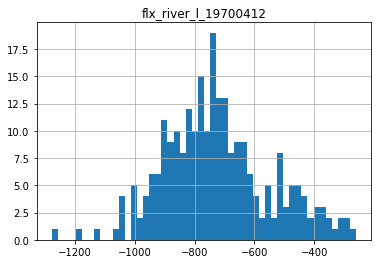

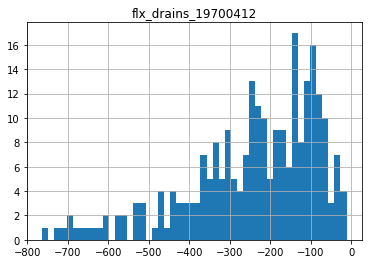

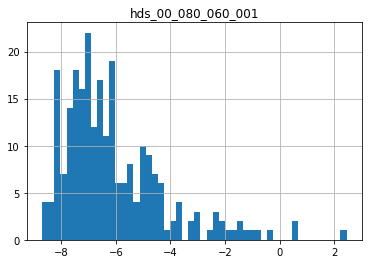

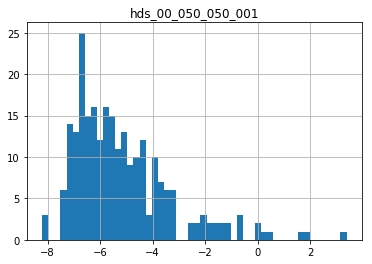

In [35]:
for cf in forecasts:
    plt.figure()
    results[cf.upper()].hist(bins=50)
    plt.title(cf)

# How about FOSM??

For this, we need a Jacobian

In [36]:
pst = pyemu.Pst(os.path.join(new_model_ws,'box.pst'))

In [37]:
pst.control_data.noptmax=-1
pst.pestpp_options['parcov'] = 'box_pest.pst.prior.cov'
pst.write(os.path.join(new_model_ws,'box.pst'))

In [38]:
pyemu.helpers.start_slaves(new_model_ws,exe_rel_path='pestpp',
                           pst_rel_path="box.pst",num_slaves=15,master_dir="master")

master:pestpp box.pst /h :4004 in master
slave:pestpp box.pst /h localhost:4004 in ../slave_0
slave:pestpp box.pst /h localhost:4004 in ../slave_1
slave:pestpp box.pst /h localhost:4004 in ../slave_2
slave:pestpp box.pst /h localhost:4004 in ../slave_3
slave:pestpp box.pst /h localhost:4004 in ../slave_4
slave:pestpp box.pst /h localhost:4004 in ../slave_5
slave:pestpp box.pst /h localhost:4004 in ../slave_6
slave:pestpp box.pst /h localhost:4004 in ../slave_7
slave:pestpp box.pst /h localhost:4004 in ../slave_8
slave:pestpp box.pst /h localhost:4004 in ../slave_9
slave:pestpp box.pst /h localhost:4004 in ../slave_10
slave:pestpp box.pst /h localhost:4004 in ../slave_11
slave:pestpp box.pst /h localhost:4004 in ../slave_12
slave:pestpp box.pst /h localhost:4004 in ../slave_13
slave:pestpp box.pst /h localhost:4004 in ../slave_14


In [39]:
pyemu.helpers.plot_summary_distributions(os.path.join("master","box.pred.usum.csv"),
                                         subplots=True)

([<matplotlib.figure.Figure at 0x11a995390>],
  <matplotlib.axes._subplots.AxesSubplot at 0x11a5b2b70>])

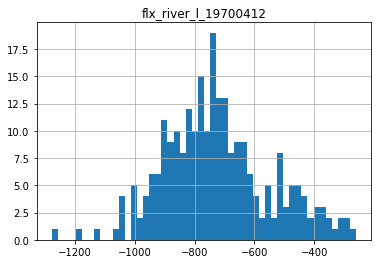

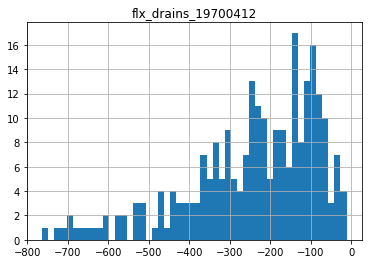

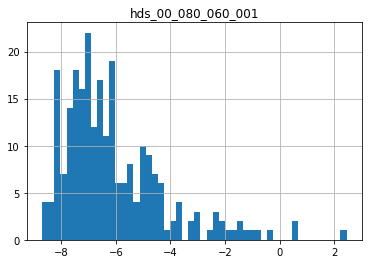

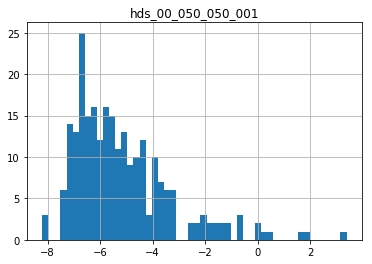

In [40]:
for cf in forecasts:
    plt.figure()
    results[cf.upper()].hist(bins=50)
    plt.title(cf)

# Shall we calibrate?

In [41]:
pst.control_data.noptmax=10
pst.pestpp_options['n_iter_base']=-1
pst.pestpp_options['n_iter_super']=5
pst.pestpp_options['parcov'] = 'box_pest.pst.prior.cov'
pst.write(os.path.join(new_model_ws,'box.pst'))

In [42]:
pyemu.helpers.start_slaves(new_model_ws,exe_rel_path='pestpp',
                           pst_rel_path="box.pst",num_slaves=15,master_dir="master")

master:pestpp box.pst /h :4004 in master
slave:pestpp box.pst /h localhost:4004 in ../slave_0
slave:pestpp box.pst /h localhost:4004 in ../slave_1
slave:pestpp box.pst /h localhost:4004 in ../slave_2
slave:pestpp box.pst /h localhost:4004 in ../slave_3
slave:pestpp box.pst /h localhost:4004 in ../slave_4
slave:pestpp box.pst /h localhost:4004 in ../slave_5
slave:pestpp box.pst /h localhost:4004 in ../slave_6
slave:pestpp box.pst /h localhost:4004 in ../slave_7
slave:pestpp box.pst /h localhost:4004 in ../slave_8
slave:pestpp box.pst /h localhost:4004 in ../slave_9
slave:pestpp box.pst /h localhost:4004 in ../slave_10
slave:pestpp box.pst /h localhost:4004 in ../slave_11
slave:pestpp box.pst /h localhost:4004 in ../slave_12
slave:pestpp box.pst /h localhost:4004 in ../slave_13
slave:pestpp box.pst /h localhost:4004 in ../slave_14


# Now we can see what we've learned about the forecasts from calibration

([<matplotlib.figure.Figure at 0x118e17278>],
  <matplotlib.axes._subplots.AxesSubplot at 0x11aeb1ef0>])

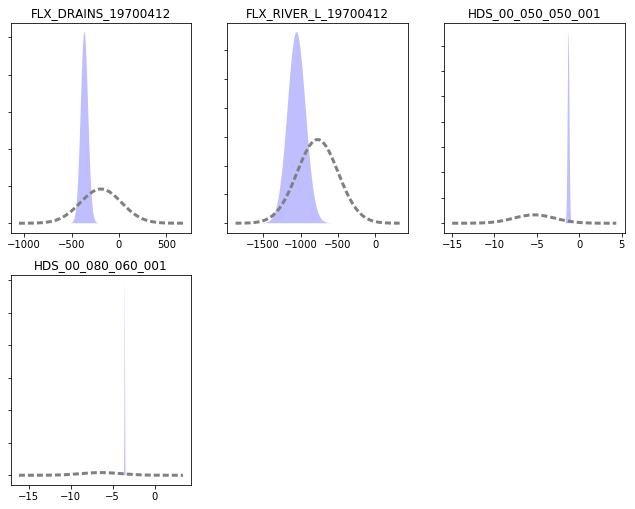

In [43]:
pyemu.helpers.plot_summary_distributions(os.path.join("master","box.pred.usum.csv"),
                                         subplots=True)

# We can sample from the posterior covariance for MC instead

In [44]:
sc_post = pyemu.Schur(jco = os.path.join('master', 'box.jcb'), 
                      parcov=os.path.join(new_model_ws,'box_pest.pst.prior.cov'))

## reset weights to reflect true performance and  update starting values with the "optimal" ones from calibration

In [45]:
pst.adjust_weights_resfile(os.path.join('master','box.rei'))
pst.parrep(os.path.join('master','box.par'))

In [46]:
mc_schur = pyemu.MonteCarlo(pst=pst,parcov=sc_post.posterior_parameter)
mc_schur.draw(num_reals=250, enforce_bounds="reset")

In [47]:
mc_schur.parensemble.to_csv(os.path.join(new_model_ws,'sweep_in.csv'))

test.ref 0.123009501906 0.12300950190639838 -1e+30
test.ref 0.1 0.1 -1e+30
test.ref 0.149266773522 0.14926677352247147 -1e+30
test.ref 0.137151293823 0.13715129382320804 -1e+30
test.ref 0.149447110351 0.1494471103509193 -1e+30
test.ref 0.13147170203 0.13147170202970482 -1e+30
test.ref 0.189286894345 0.18928689434463838 -1e+30
test.ref 0.125766144811 0.12576614481136492 -1e+30
test.ref 0.168390577726 0.1683905777256472 -1e+30
test.ref 0.178111312736 0.17811131273589878 -1e+30


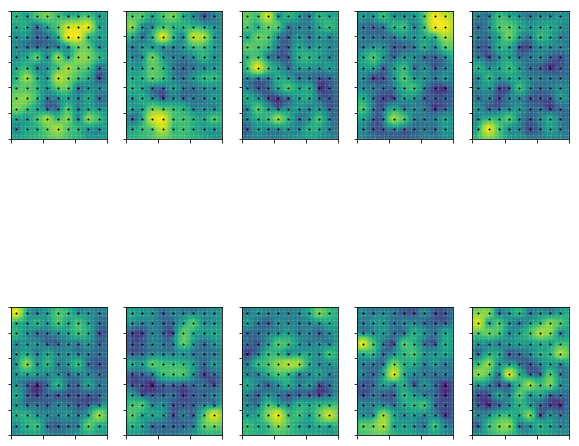

In [48]:
plot_first_10_reals(mc_schur.parensemble)

In [49]:
pyemu.helpers.start_slaves(new_model_ws,exe_rel_path='sweep',
                           pst_rel_path="box.pst",num_slaves=15,master_dir="master")

master:sweep box.pst /h :4004 in master
slave:sweep box.pst /h localhost:4004 in ../slave_0
slave:sweep box.pst /h localhost:4004 in ../slave_1
slave:sweep box.pst /h localhost:4004 in ../slave_2
slave:sweep box.pst /h localhost:4004 in ../slave_3
slave:sweep box.pst /h localhost:4004 in ../slave_4
slave:sweep box.pst /h localhost:4004 in ../slave_5
slave:sweep box.pst /h localhost:4004 in ../slave_6
slave:sweep box.pst /h localhost:4004 in ../slave_7
slave:sweep box.pst /h localhost:4004 in ../slave_8
slave:sweep box.pst /h localhost:4004 in ../slave_9
slave:sweep box.pst /h localhost:4004 in ../slave_10
slave:sweep box.pst /h localhost:4004 in ../slave_11
slave:sweep box.pst /h localhost:4004 in ../slave_12
slave:sweep box.pst /h localhost:4004 in ../slave_13
slave:sweep box.pst /h localhost:4004 in ../slave_14


In [50]:
results2 = pd.read_csv(os.path.join('master','sweep_out.csv'))

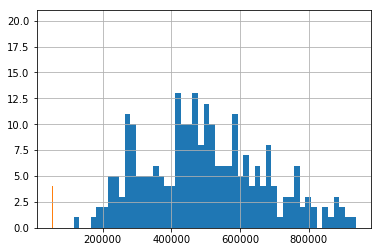

In [51]:
ax = results.phi.hist(bins=50)
results2.phi.hist(bins=50, ax=ax)

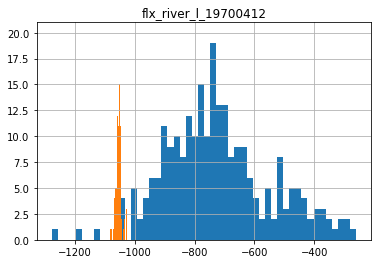

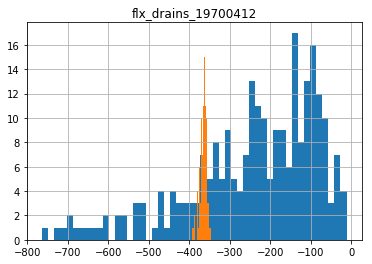

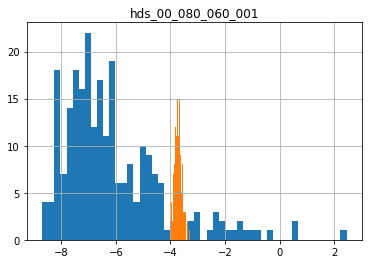

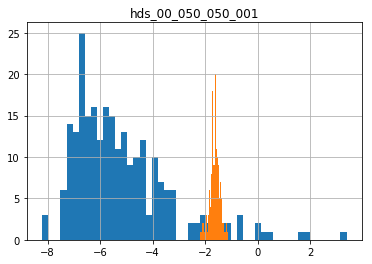

In [52]:
for cf in forecasts:
    plt.figure()
    ax = results[cf.upper()].hist(bins=50)
    results2[cf.upper()].hist(bins=50, ax=ax)
    plt.title(cf)